(mmm_counterfactual)=
# Causal inference in `pymc-marketing`

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
plt.rcParams["figure.figsize"] = [12, 7]

In [4]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Data generation

Taken from https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html

In [5]:
def forward_pass(df_in):
    """Run predictor variables through the forward pass of the model.

    Given a dataframe with spend data columns `x1` and `x2`, run this through the
    transformations and return the response variable `y`.
    """
    df = df_in.copy()

    n = df.shape[0]

    # apply geometric adstock transformation
    alpha1: float = 0.4
    alpha2: float = 0.2

    df["x1_adstock"] = (
        geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
        .eval()
        .flatten()
    )

    df["x2_adstock"] = (
        geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
        .eval()
        .flatten()
    )

    # apply saturation transformation
    lam1: float = 4.0
    lam2: float = 3.0

    df["x1_adstock_saturated"] = logistic_saturation(
        x=df["x1_adstock"].to_numpy(), lam=lam1
    ).eval()

    df["x2_adstock_saturated"] = logistic_saturation(
        x=df["x2_adstock"].to_numpy(), lam=lam2
    ).eval()

    # trend and seasonality
    df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

    df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
    df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

    # random events
    df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
    df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

    df["intercept"] = 2.0
    if "epsilon" not in df.columns:
        df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

    amplitude = 1
    beta_1 = 3.0
    beta_2 = 2.0

    # forward pass
    df["y"] = amplitude * (
        df["intercept"]
        + df["trend"]
        + df["seasonality"]
        + 1.5 * df["event_1"]
        + 2.5 * df["event_2"]
        + beta_1 * df["x1_adstock_saturated"]
        + beta_2 * df["x2_adstock_saturated"]
        + df["epsilon"]
    )
    return df


def generate_counterfactual_dataset(rng):
    """Generate a synthetic dataset.

    For the counterfactual scenario of no advertising campaign.
    """
    # date range
    min_date = pd.to_datetime("2018-04-01")
    max_date = pd.to_datetime("2021-09-01")

    df = pd.DataFrame(
        data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
    ).assign(
        year=lambda x: x["date_week"].dt.year,
        month=lambda x: x["date_week"].dt.month,
        dayofyear=lambda x: x["date_week"].dt.dayofyear,
    )

    n = df.shape[0]
    print(f"Number of observations: {n}")

    # media data
    x1 = rng.uniform(low=0.0, high=1.0, size=n)
    df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

    x2 = rng.uniform(low=0.0, high=1.0, size=n)
    df["x2"] = np.where(x2 > 0.8, x2, 0)

    df = forward_pass(df)
    return df

In [6]:
df_counterfactual = generate_counterfactual_dataset(rng)
df_counterfactual.head()

Number of observations: 179


date_week  year  month  dayofyear        x1   x2  x1_adstock  x2_adstock  \
0 2018-04-02  2018      4         92  0.318580  0.0    0.191273         0.0   
1 2018-04-09  2018      4         99  0.112388  0.0    0.143987         0.0   
2 2018-04-16  2018      4        106  0.292400  0.0    0.233150         0.0   
3 2018-04-23  2018      4        113  0.071399  0.0    0.136127         0.0   
4 2018-04-30  2018      4        120  0.386745  0.0    0.286650         0.0   

   x1_adstock_saturated  x2_adstock_saturated     trend        cs        cc  \
0              0.364917                   0.0  0.778279  0.021487 -0.010744   
1              0.280268                   0.0  0.790638  0.259165 -0.130704   
2              0.435205                   0.0  0.802746  0.481904 -0.248773   
3              0.265721                   0.0  0.814614  0.676865 -0.363245   
4              0.517779                   0.0  0.826254  0.832810 -0.472462   

   seasonality  event_1  event_2  intercept   epsilon         y  
0     0.005371      0.0      0.0        2.0  0.106260  3.984662  
1     0.064231      0.0      0.0        2.0  0.067198  3.762872  
2     0.116566      0.0      0.0        2.0  0.242042  4.466967  
3     0.156810      0.0      0.0        2.0  0.095631  3.864219  
4     0.180174      0.0      0.0        2.0 -0.118140  4.441625

Now generate a dataframe for the _actual_ situation where an experimental intervention took place. This will be a period of time where media spend was increased.

In [7]:
intervention_date = "2021-01-01"

In [8]:
def generate_actual_dataset(
    df_counterfactual: pd.DataFrame, intervention_date
) -> pd.DataFrame:
    """Generate the 'actual' dataset.

    Based on the counterfactual dataset, apply the intervention on the specified date
    and return the actual dataset.
    """
    df = df_counterfactual[["date_week", "dayofyear", "x1", "x2", "epsilon"]].copy()

    # increase x1 by 40% in for date_week from 2021-01-01 onwards
    # df['x1_actual'] = df_counterfactual['x1']
    df.loc[df["date_week"] > "2021-01-01", "x1"] *= 1.40

    df = forward_pass(df)

    return df


df_actual = generate_actual_dataset(df_counterfactual, intervention_date)

df_actual.head()

date_week  dayofyear        x1   x2   epsilon  x1_adstock  x2_adstock  \
0 2018-04-02         92  0.318580  0.0  0.106260    0.191273         0.0   
1 2018-04-09         99  0.112388  0.0  0.067198    0.143987         0.0   
2 2018-04-16        106  0.292400  0.0  0.242042    0.233150         0.0   
3 2018-04-23        113  0.071399  0.0  0.095631    0.136127         0.0   
4 2018-04-30        120  0.386745  0.0 -0.118140    0.286650         0.0   

   x1_adstock_saturated  x2_adstock_saturated     trend        cs        cc  \
0              0.364917                   0.0  0.778279  0.021487 -0.010744   
1              0.280268                   0.0  0.790638  0.259165 -0.130704   
2              0.435205                   0.0  0.802746  0.481904 -0.248773   
3              0.265721                   0.0  0.814614  0.676865 -0.363245   
4              0.517779                   0.0  0.826254  0.832810 -0.472462   

   seasonality  event_1  event_2  intercept         y  
0     0.005371      0.0      0.0        2.0  3.984662  
1     0.064231      0.0      0.0        2.0  3.762872  
2     0.116566      0.0      0.0        2.0  4.466967  
3     0.156810      0.0      0.0        2.0  3.864219  
4     0.180174      0.0      0.0        2.0  4.441625

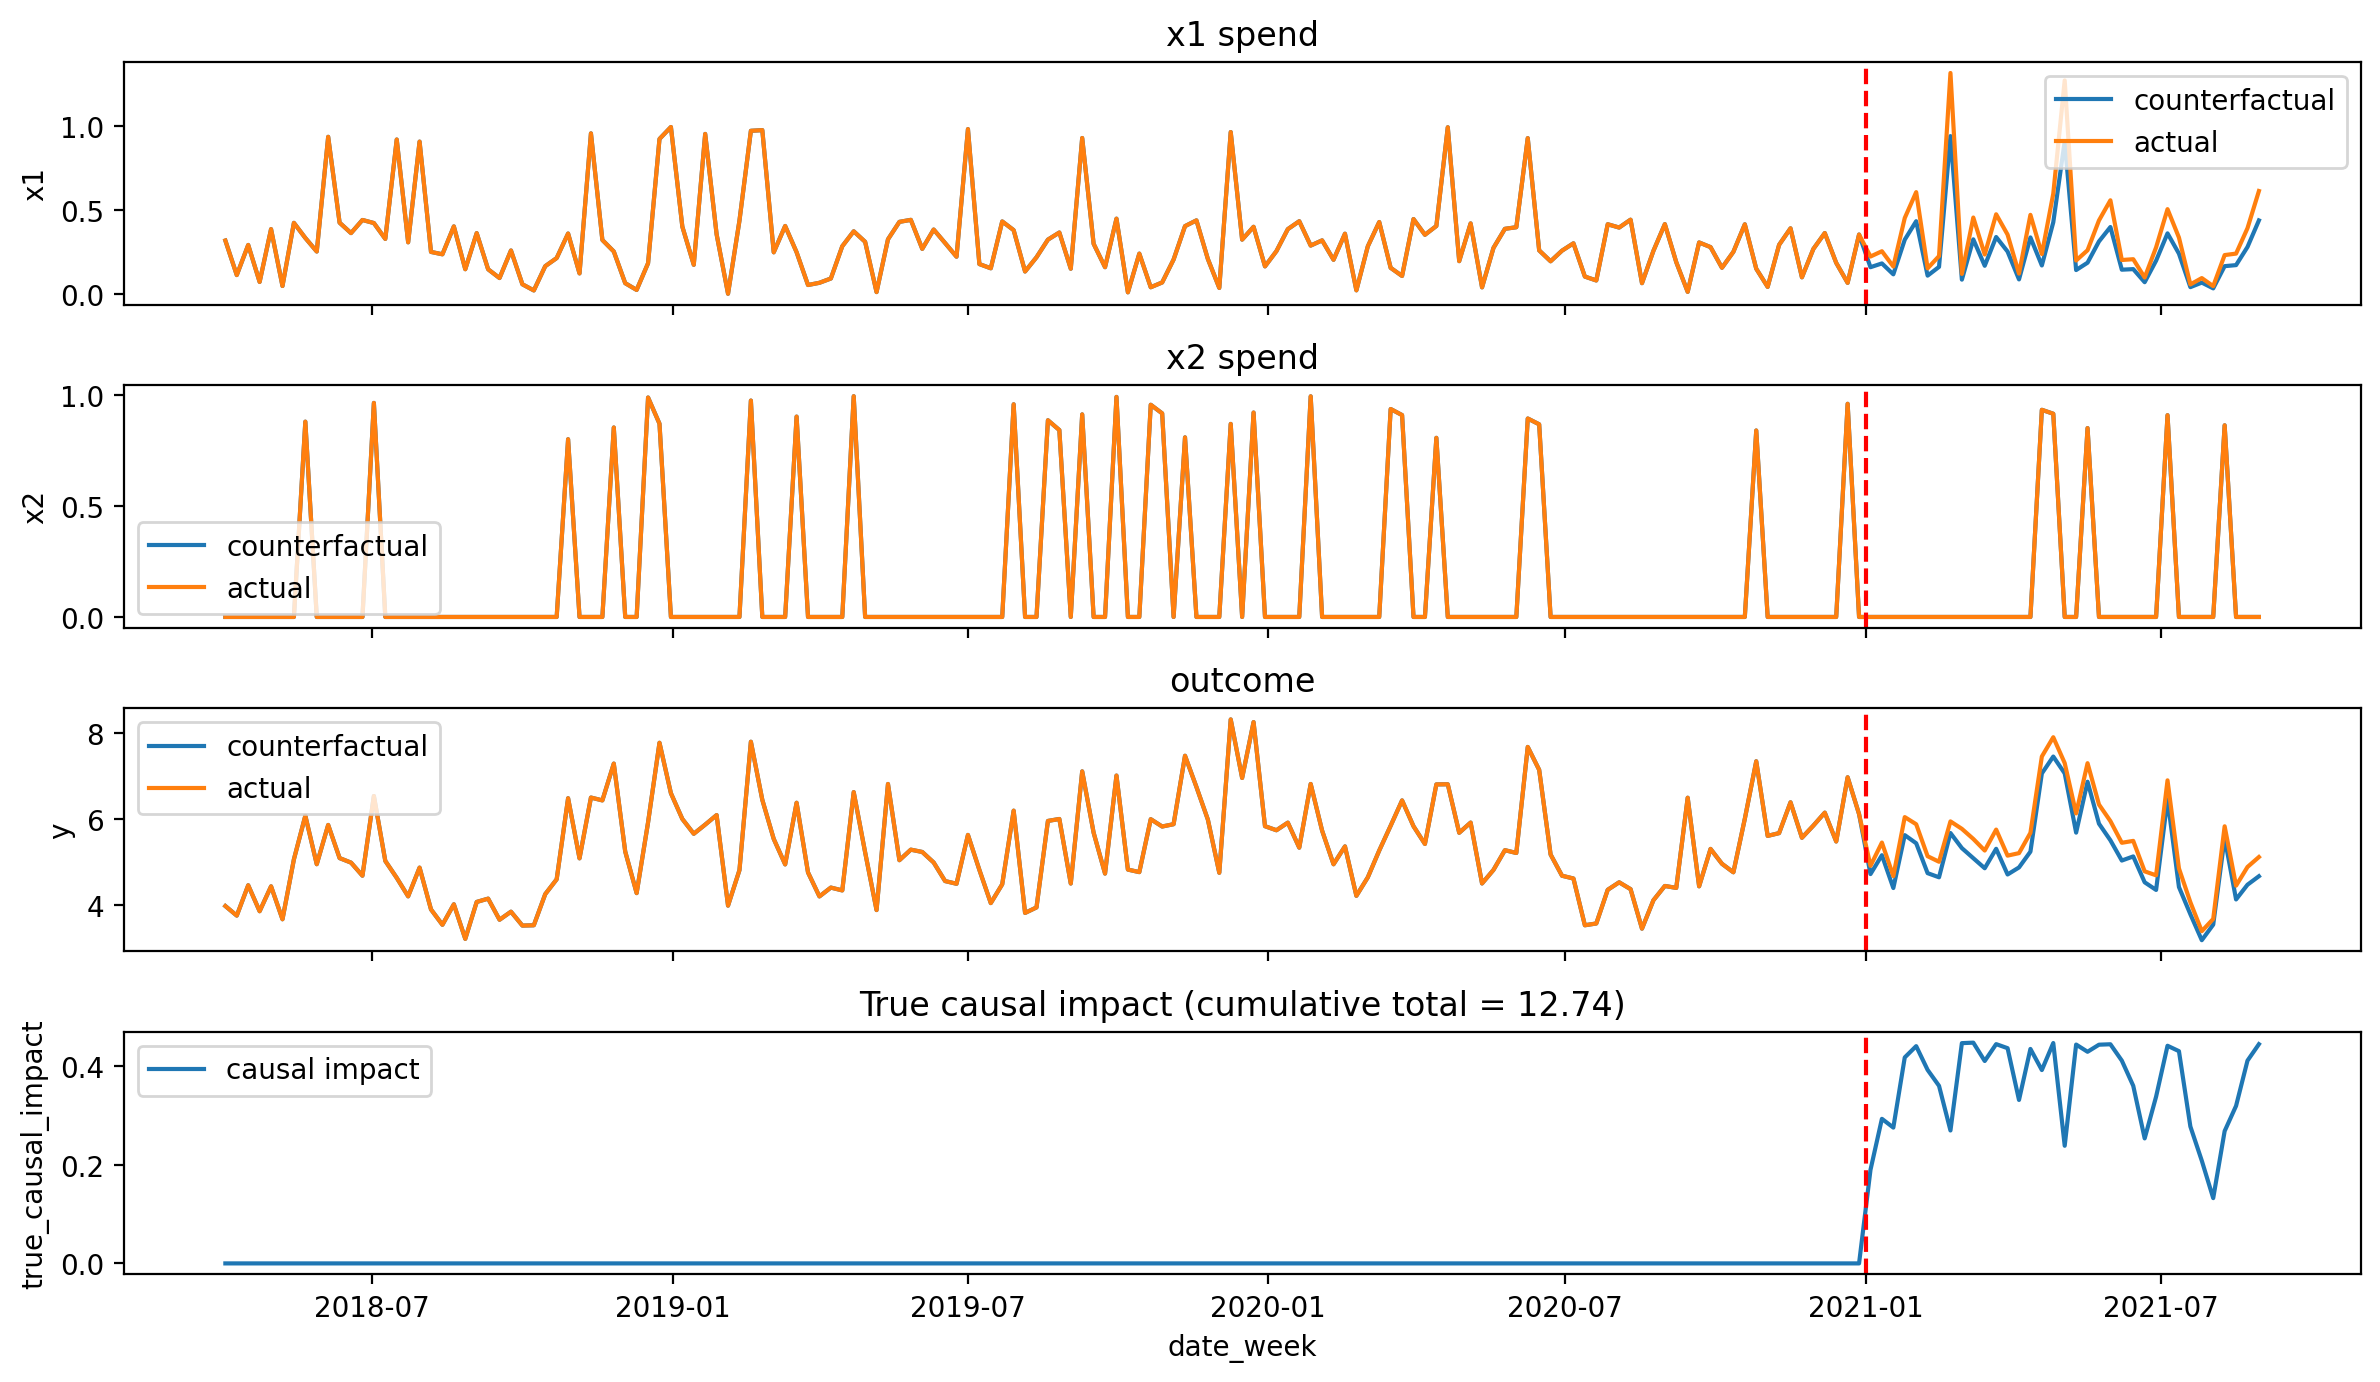

In [9]:
fig, ax = plt.subplots(4, 1, sharex=True)

sns.lineplot(
    x="date_week", y="x1", data=df_counterfactual, label="counterfactual", ax=ax[0]
)
sns.lineplot(x="date_week", y="x1", data=df_actual, label="actual", ax=ax[0])
ax[0].set(title="x1 spend")

sns.lineplot(
    x="date_week", y="x2", data=df_counterfactual, label="counterfactual", ax=ax[1]
)
sns.lineplot(x="date_week", y="x2", data=df_actual, label="actual", ax=ax[1])
ax[1].set(title="x2 spend")

sns.lineplot(
    x="date_week", y="y", data=df_counterfactual, label="counterfactual", ax=ax[2]
)
sns.lineplot(x="date_week", y="y", data=df_actual, label="actual", ax=ax[2])
ax[2].set(title="outcome")

# calculate true causal impact
new_df = pd.DataFrame()
new_df["date_week"] = df_actual["date_week"]
new_df["true_causal_impact"] = df_actual["y"] - df_counterfactual["y"]

sns.lineplot(
    x="date_week", y="true_causal_impact", data=new_df, label="causal impact", ax=ax[3]
)
cumulative_impact = new_df["true_causal_impact"].sum()
ax[3].set(title=f"True causal impact (cumulative total = {cumulative_impact:.2f})")

# plot intervention point
for i in [0, 1, 2, 3]:
    ax[i].axvline(
        x=pd.to_datetime(intervention_date),
        color="red",
        linestyle="--",
        label="intervention date",
    )

plt.tight_layout();

Because we are simulating this world, we know the true causal impact.

## Inference

In the real world, we only have access to the df_actual data. Our goal will be to infer the causal impact of the intervention.

* Train MMM on data available to us in df_actual. This will include the whole time series available to us.
* Evaluate the model's predictions in the counterfactual world where the intervention did not take place.
  * This will be done by using `pm.set_data` so that x1 is equal to the spend in the counterfactual world where no intervention took place. So this approach does assume that we know (or can estimate) the counterfactual spend.


### Feature engineering

In [10]:
data = df_actual.copy()

In [11]:
n = data.shape[0]
data["t"] = range(n)

In [12]:
data.head()

date_week  dayofyear        x1   x2   epsilon  x1_adstock  x2_adstock  \
0 2018-04-02         92  0.318580  0.0  0.106260    0.191273         0.0   
1 2018-04-09         99  0.112388  0.0  0.067198    0.143987         0.0   
2 2018-04-16        106  0.292400  0.0  0.242042    0.233150         0.0   
3 2018-04-23        113  0.071399  0.0  0.095631    0.136127         0.0   
4 2018-04-30        120  0.386745  0.0 -0.118140    0.286650         0.0   

   x1_adstock_saturated  x2_adstock_saturated     trend        cs        cc  \
0              0.364917                   0.0  0.778279  0.021487 -0.010744   
1              0.280268                   0.0  0.790638  0.259165 -0.130704   
2              0.435205                   0.0  0.802746  0.481904 -0.248773   
3              0.265721                   0.0  0.814614  0.676865 -0.363245   
4              0.517779                   0.0  0.826254  0.832810 -0.472462   

   seasonality  event_1  event_2  intercept         y  t  
0     0.005371      0.0      0.0        2.0  3.984662  0  
1     0.064231      0.0      0.0        2.0  3.762872  1  
2     0.116566      0.0      0.0        2.0  4.466967  2  
3     0.156810      0.0      0.0        2.0  3.864219  3  
4     0.180174      0.0      0.0        2.0  4.441625  4

### MMM model

In [13]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.670295
x2    0.329705
dtype: float64

In [14]:
n_channels = 2

prior_sigma = n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[1.3405909541866248, 0.6594090458133751]

In [15]:
X = data.drop("y", axis=1)
y = data["y"]

In [16]:
my_model_config = {
    "intercept": {"dist": "Normal", "kwargs": {"mu": 0, "sigma": 0.5}},
    "saturation_beta": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": prior_sigma},
    },
    "gamma_control": {
        "dist": "Normal",
        "kwargs": {"mu": 0, "sigma": 0.05},
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 0.2},
    },
    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}
            # Also possible define sigma as:
            # {'sigma': 5}
        },
    },
}

In [17]:
my_sampler_config = {"progressbar": True}

In [18]:
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    yearly_seasonality=2,
)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]


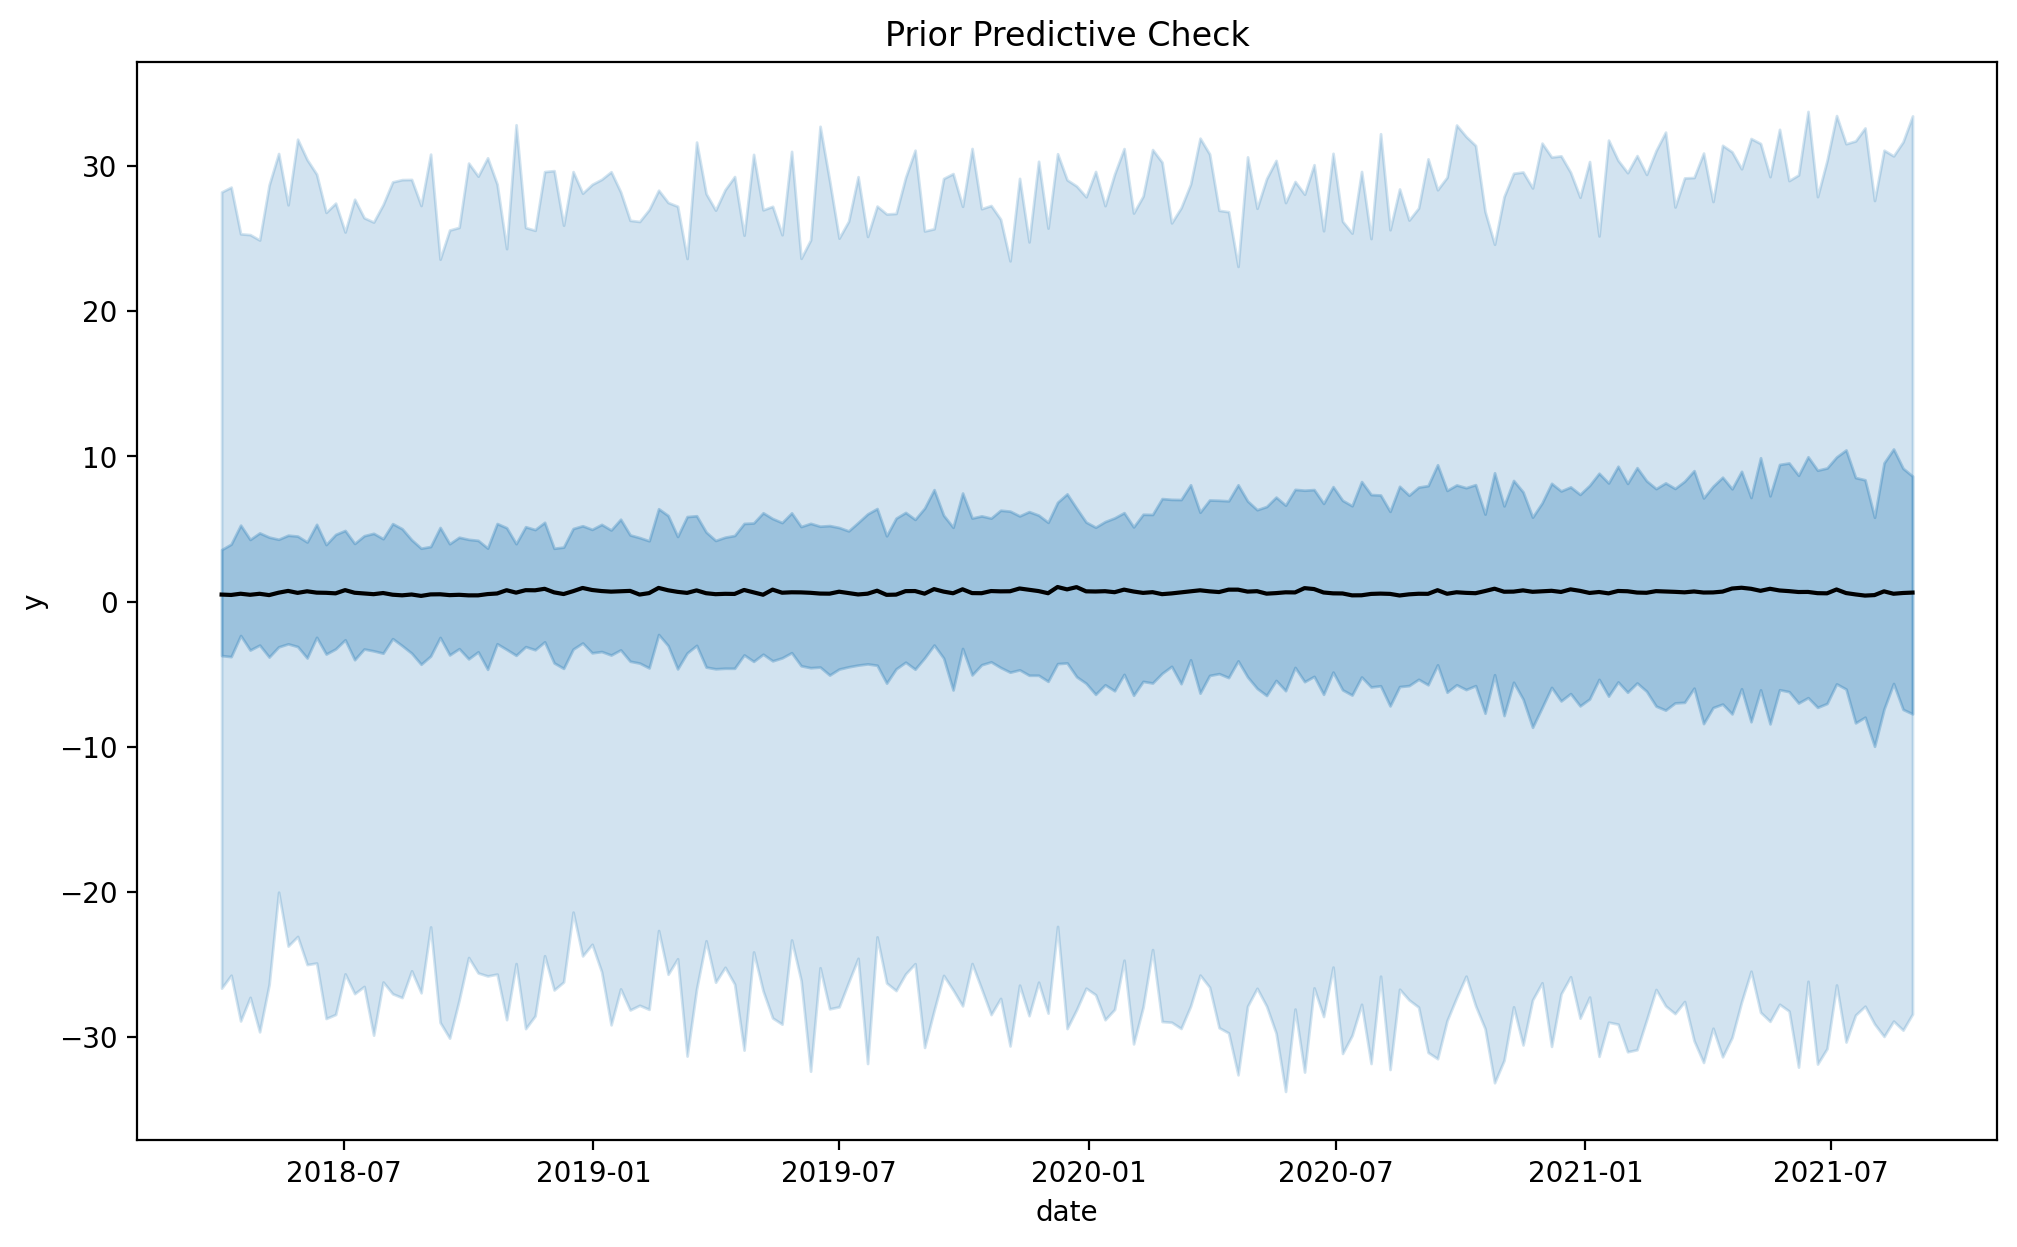

In [19]:
mmm.sample_prior_predictive(X, y, samples=2_000)

mmm.plot_prior_predictive();

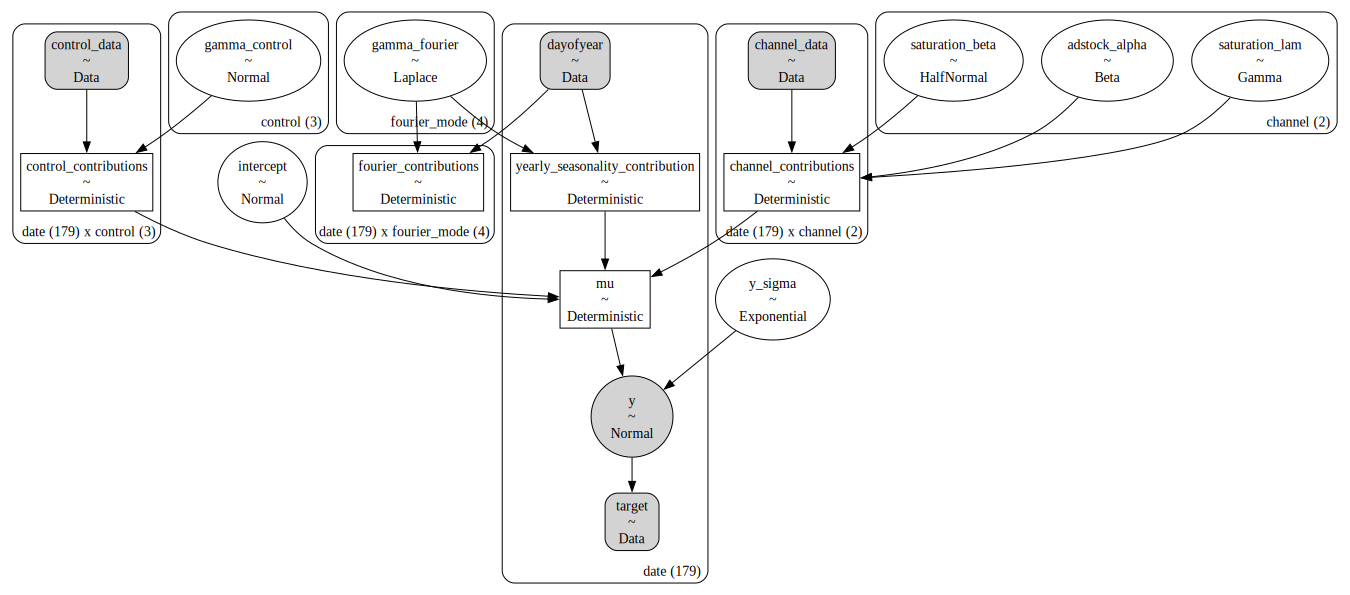

In [20]:
pm.model_to_graphviz(model=mmm.model)

In [21]:
mmm.fit(X=X, y=y, target_accept=0.85, chains=4, nuts_sampler="numpyro", random_seed=rng)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

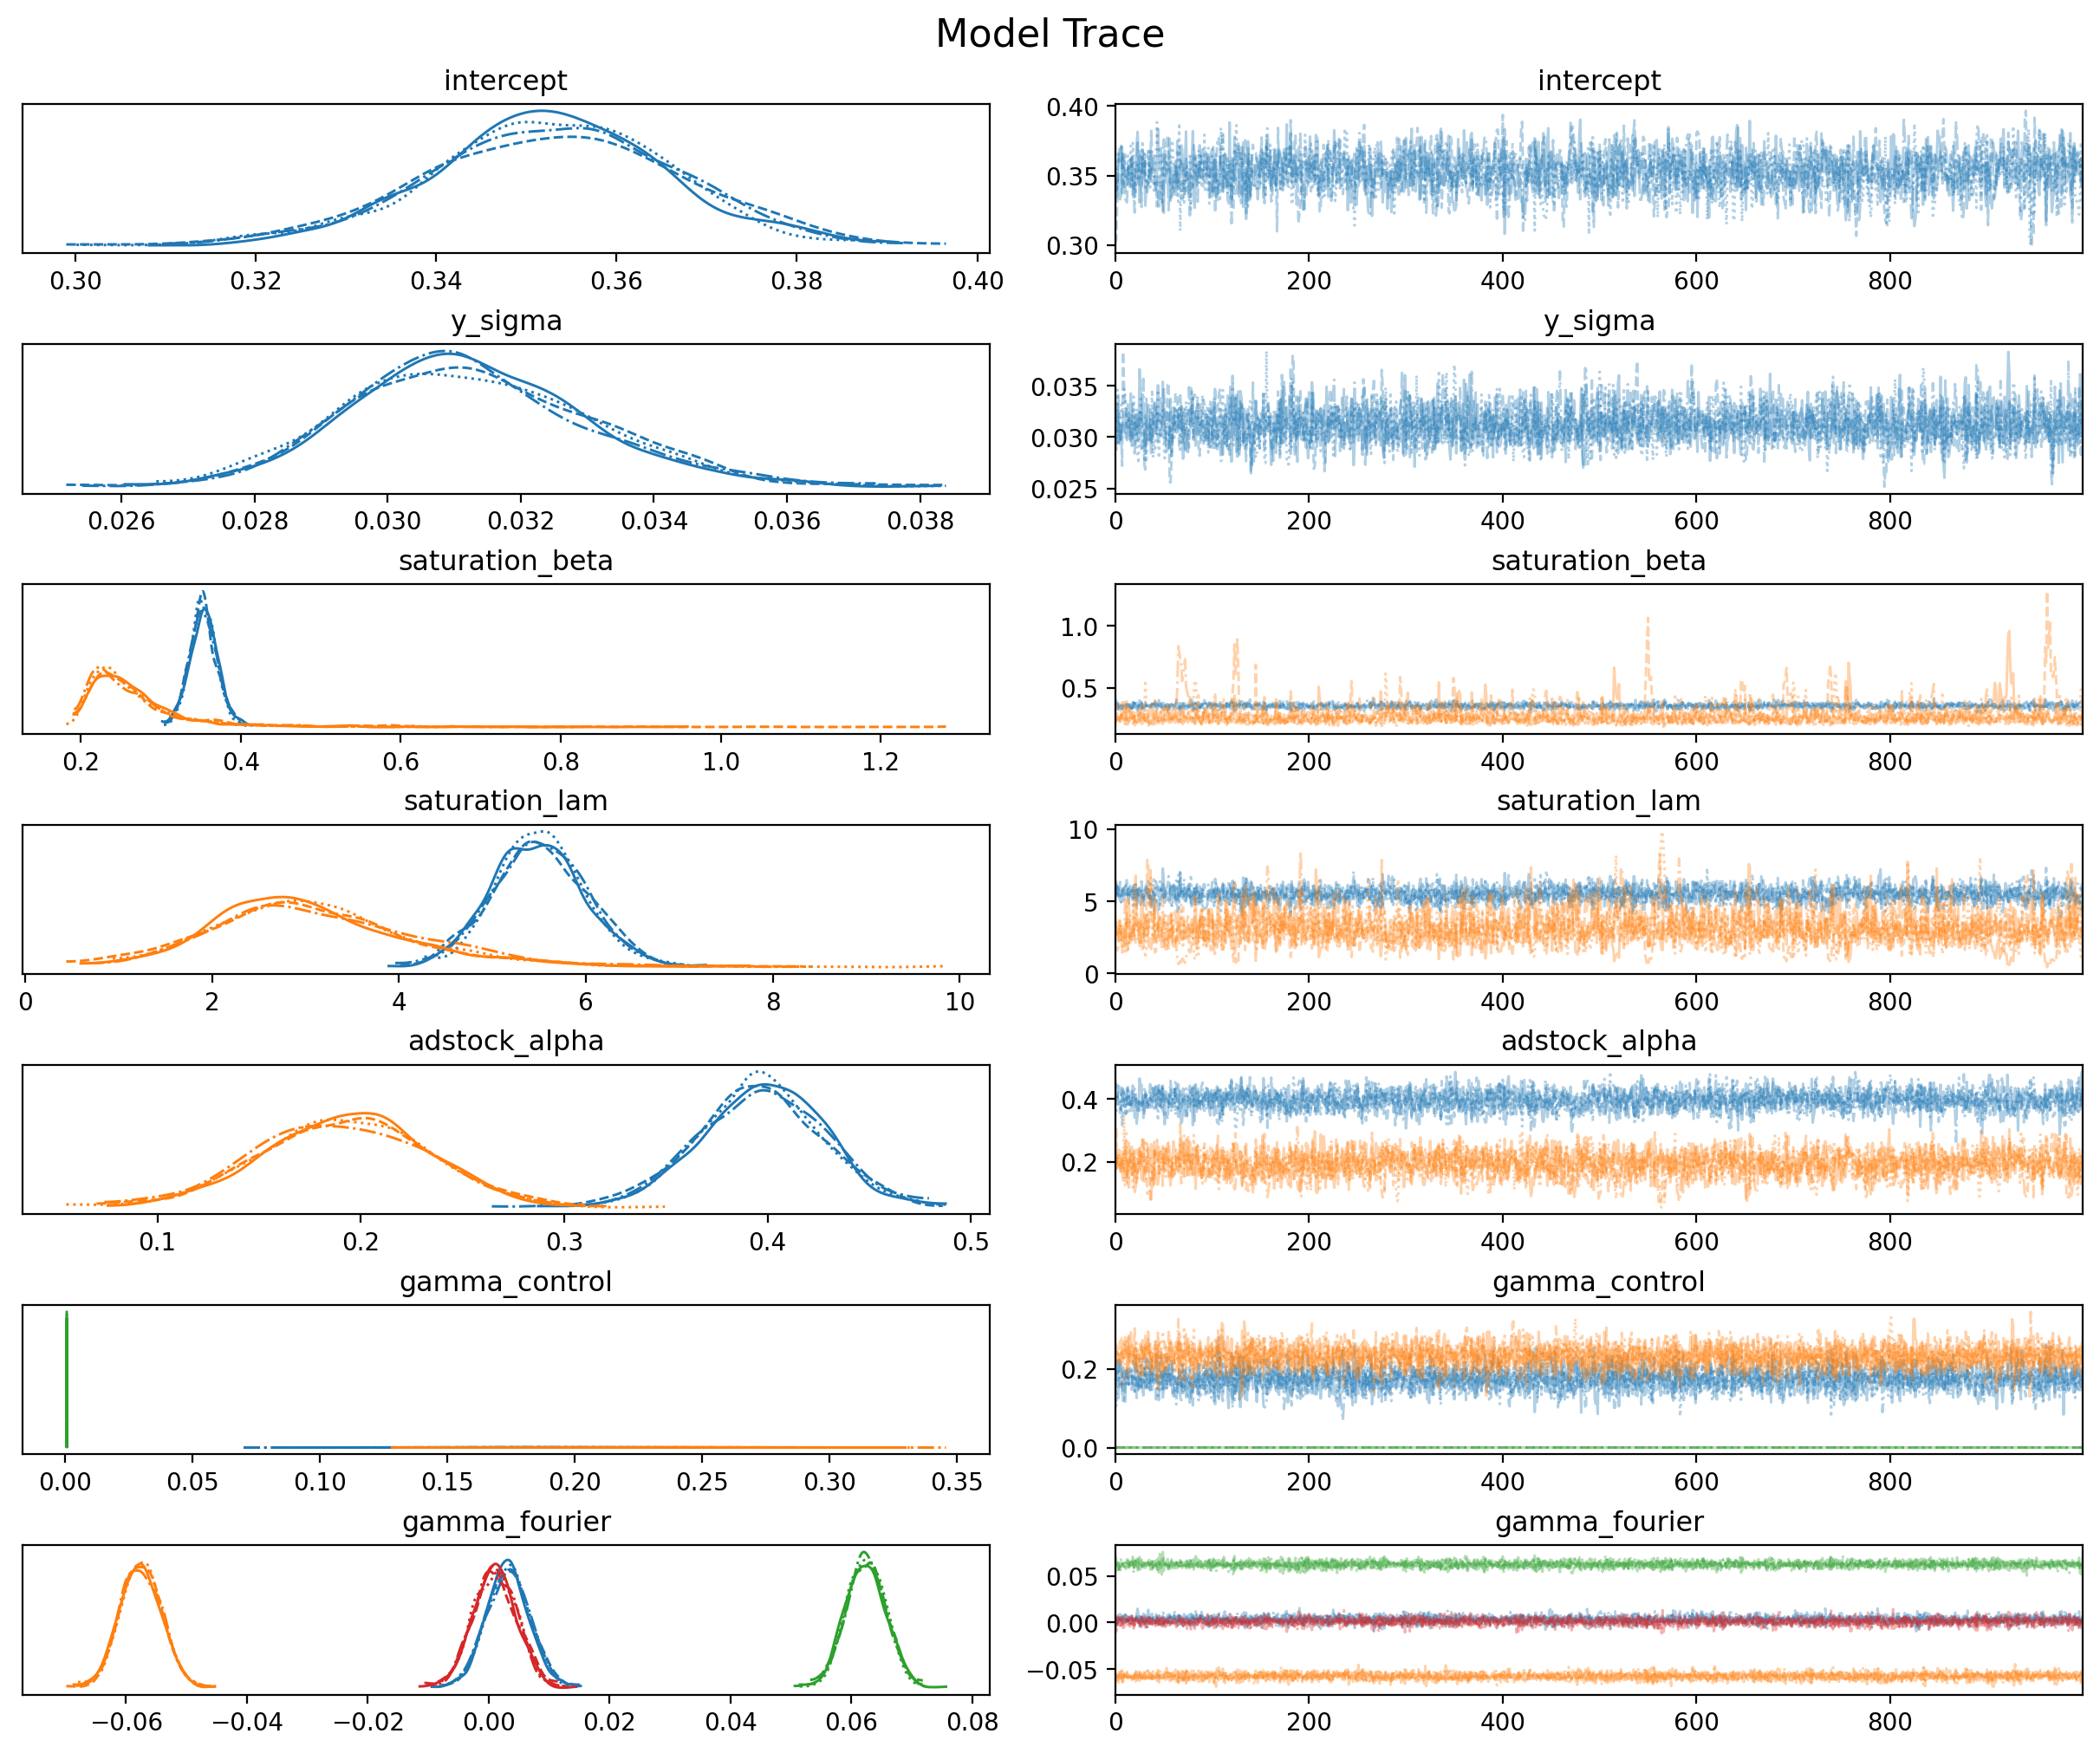

In [22]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [23]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (sample: 4000, date: 179)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 3.923 3.809 4.027 ... 5.391 6.099 5.415
Attributes:
    created_at:                 2024-09-13T16:43:09.661769+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.15.0

The plot below represents the MMM fit to the actual data

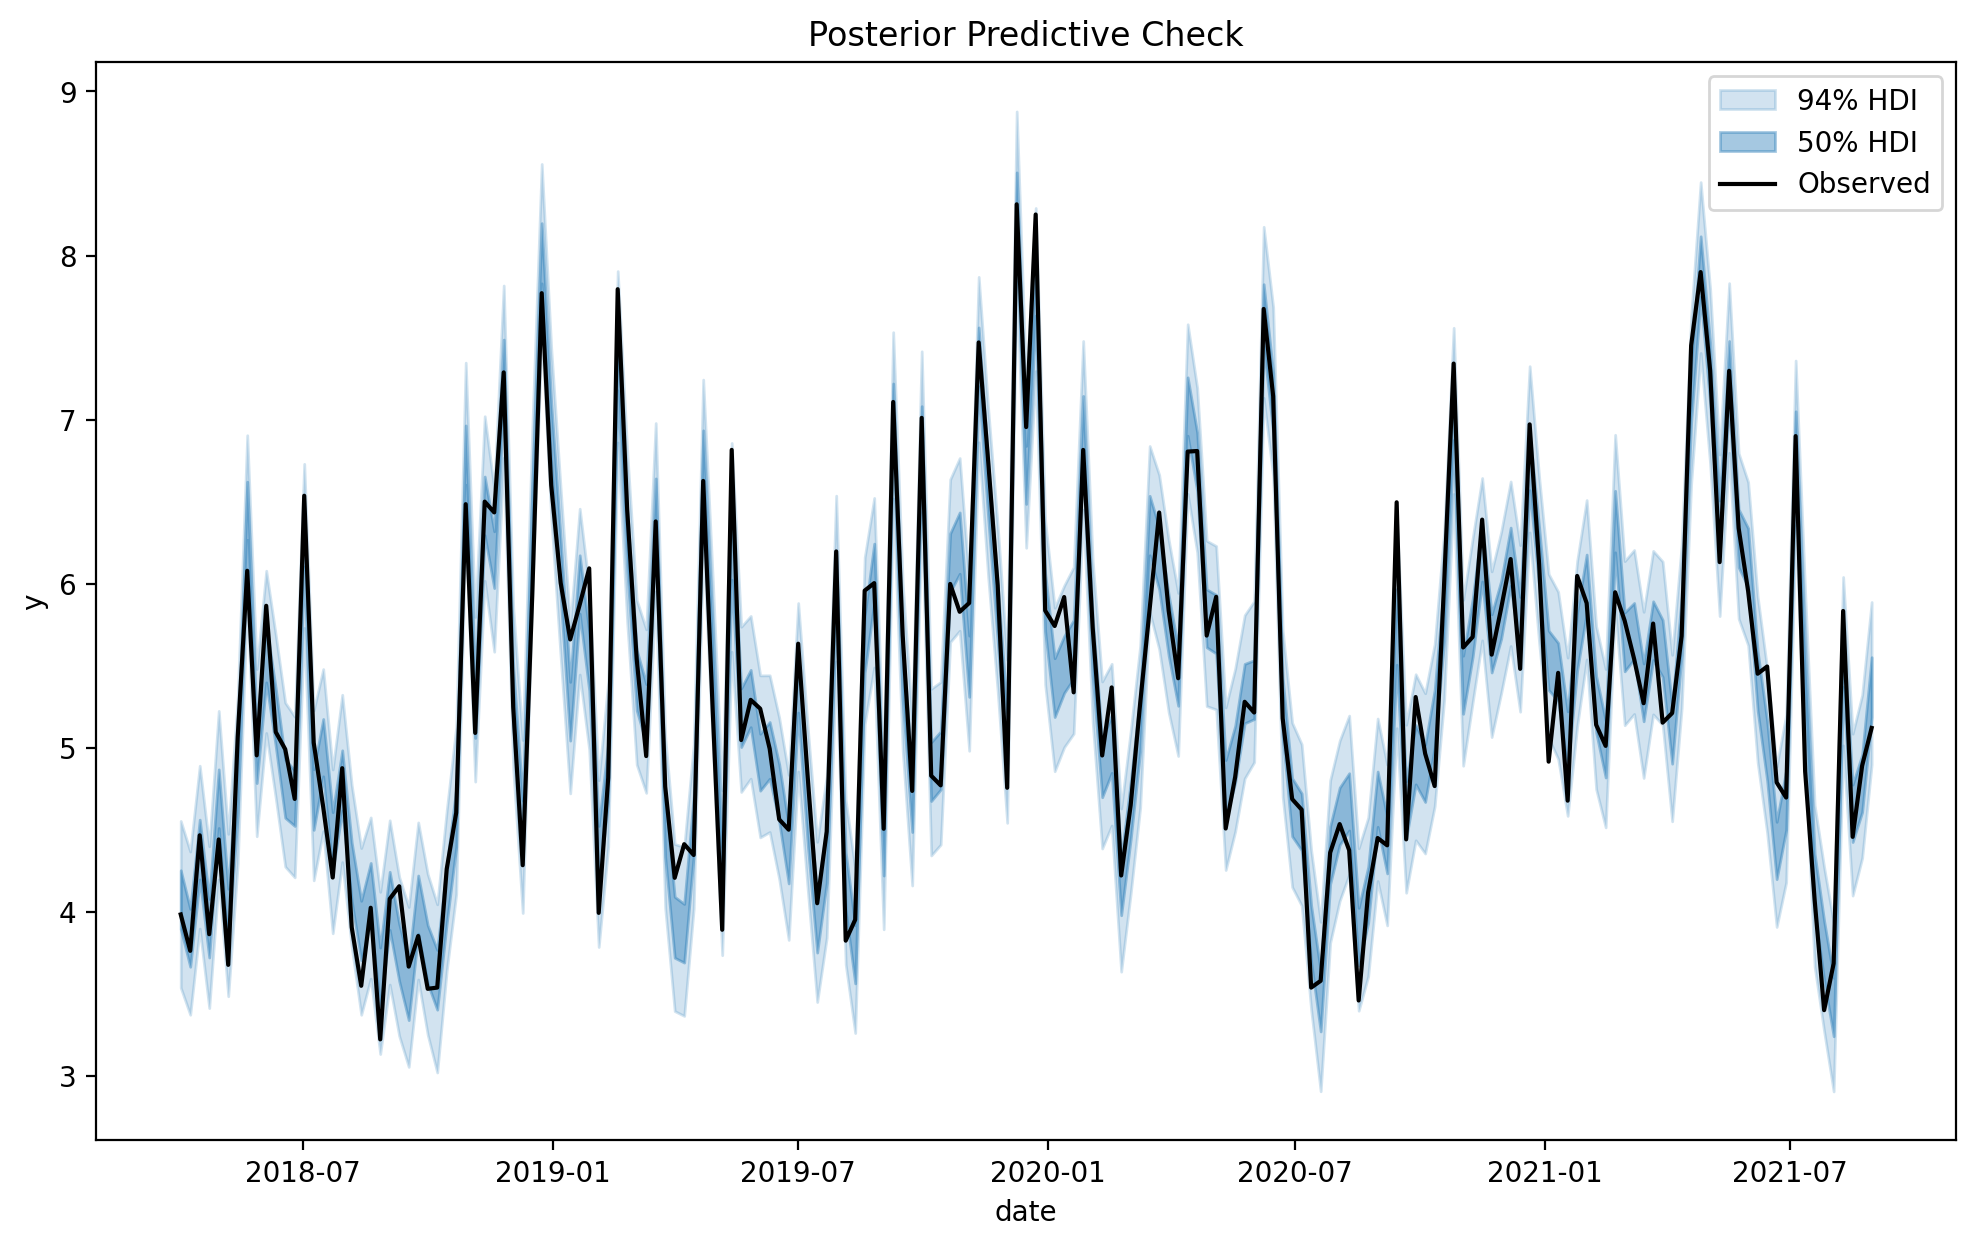

In [24]:
mmm.plot_posterior_predictive(original_scale=True);

## Counterfactual prediction

Now we want to evaluate what the model thinks would have happened in the counterfactual scenario that the intervention did not take place. For this, we will use the counterfactual spend in `df_counterfactual.x1`.

In [25]:
X_counterfactual = df_counterfactual[["date_week", "x1", "x2", "event_1", "event_2"]]

X_counterfactual["t"] = range(n)

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_42891/1725234939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_counterfactual["t"] = range(n)


In [26]:
X_counterfactual.head()

date_week        x1   x2  event_1  event_2  t
0 2018-04-02  0.318580  0.0      0.0      0.0  0
1 2018-04-09  0.112388  0.0      0.0      0.0  1
2 2018-04-16  0.292400  0.0      0.0      0.0  2
3 2018-04-23  0.071399  0.0      0.0      0.0  3
4 2018-04-30  0.386745  0.0      0.0      0.0  4

In [27]:
y_counterfactual = mmm.sample_posterior_predictive(
    X_pred=X_counterfactual, extend_idata=False
)

y_counterfactual

Sampling: [y]


Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (sample: 4000, date: 179)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 3.874 4.375 4.094 ... 4.683 4.669 4.529
Attributes:
    created_at:                 2024-09-13T16:43:10.930694+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.15.0

### Calculate the causal impact

In [28]:
# y_dataarray = df_actual["y"].to_xarray().rename("y")
# y_dataarray

In [29]:
# Calculate causal impact
y_obs = xr.DataArray(df_actual["y"].to_numpy(), dims=["date"])
causal_impact = y_obs - y_counterfactual["y"]
causal_impact

<xarray.DataArray (date: 179, sample: 4000)> Size: 6MB
array([[ 0.11078438, -0.39070091, -0.10932984, ..., -0.13863578,
        -0.28301391, -0.2819685 ],
       [-0.2565592 , -0.09072103,  0.33063565, ..., -0.05157979,
        -0.25690724,  0.14611584],
       [ 0.31328751, -0.1751461 , -0.13747889, ..., -0.10722026,
        -0.16325789,  0.24563406],
       ...,
       [ 0.06633847, -0.0154356 ,  0.15689947, ...,  0.45687344,
         0.46088227, -0.34452654],
       [ 0.50737831,  0.71891041,  0.47288656, ...,  0.83912398,
         0.55139608,  0.19083777],
       [ 0.24326992,  0.32234562,  0.25892027, ...,  0.43855472,
         0.45184591,  0.59253178]])
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

### Plot counterfactual predictions

/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_42891/2404514098.py:9: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_counterfactual["date_week"].dt.to_pydatetime(),
/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_42891/2404514098.py:20: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  X_counterfactual["date_week"].dt.to_pydatetime(),
/var/folders/pd/p2qnky2x3xl4w3mgc4lct2200000gn/T/ipykernel_42891/2404514098.py:40: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instea

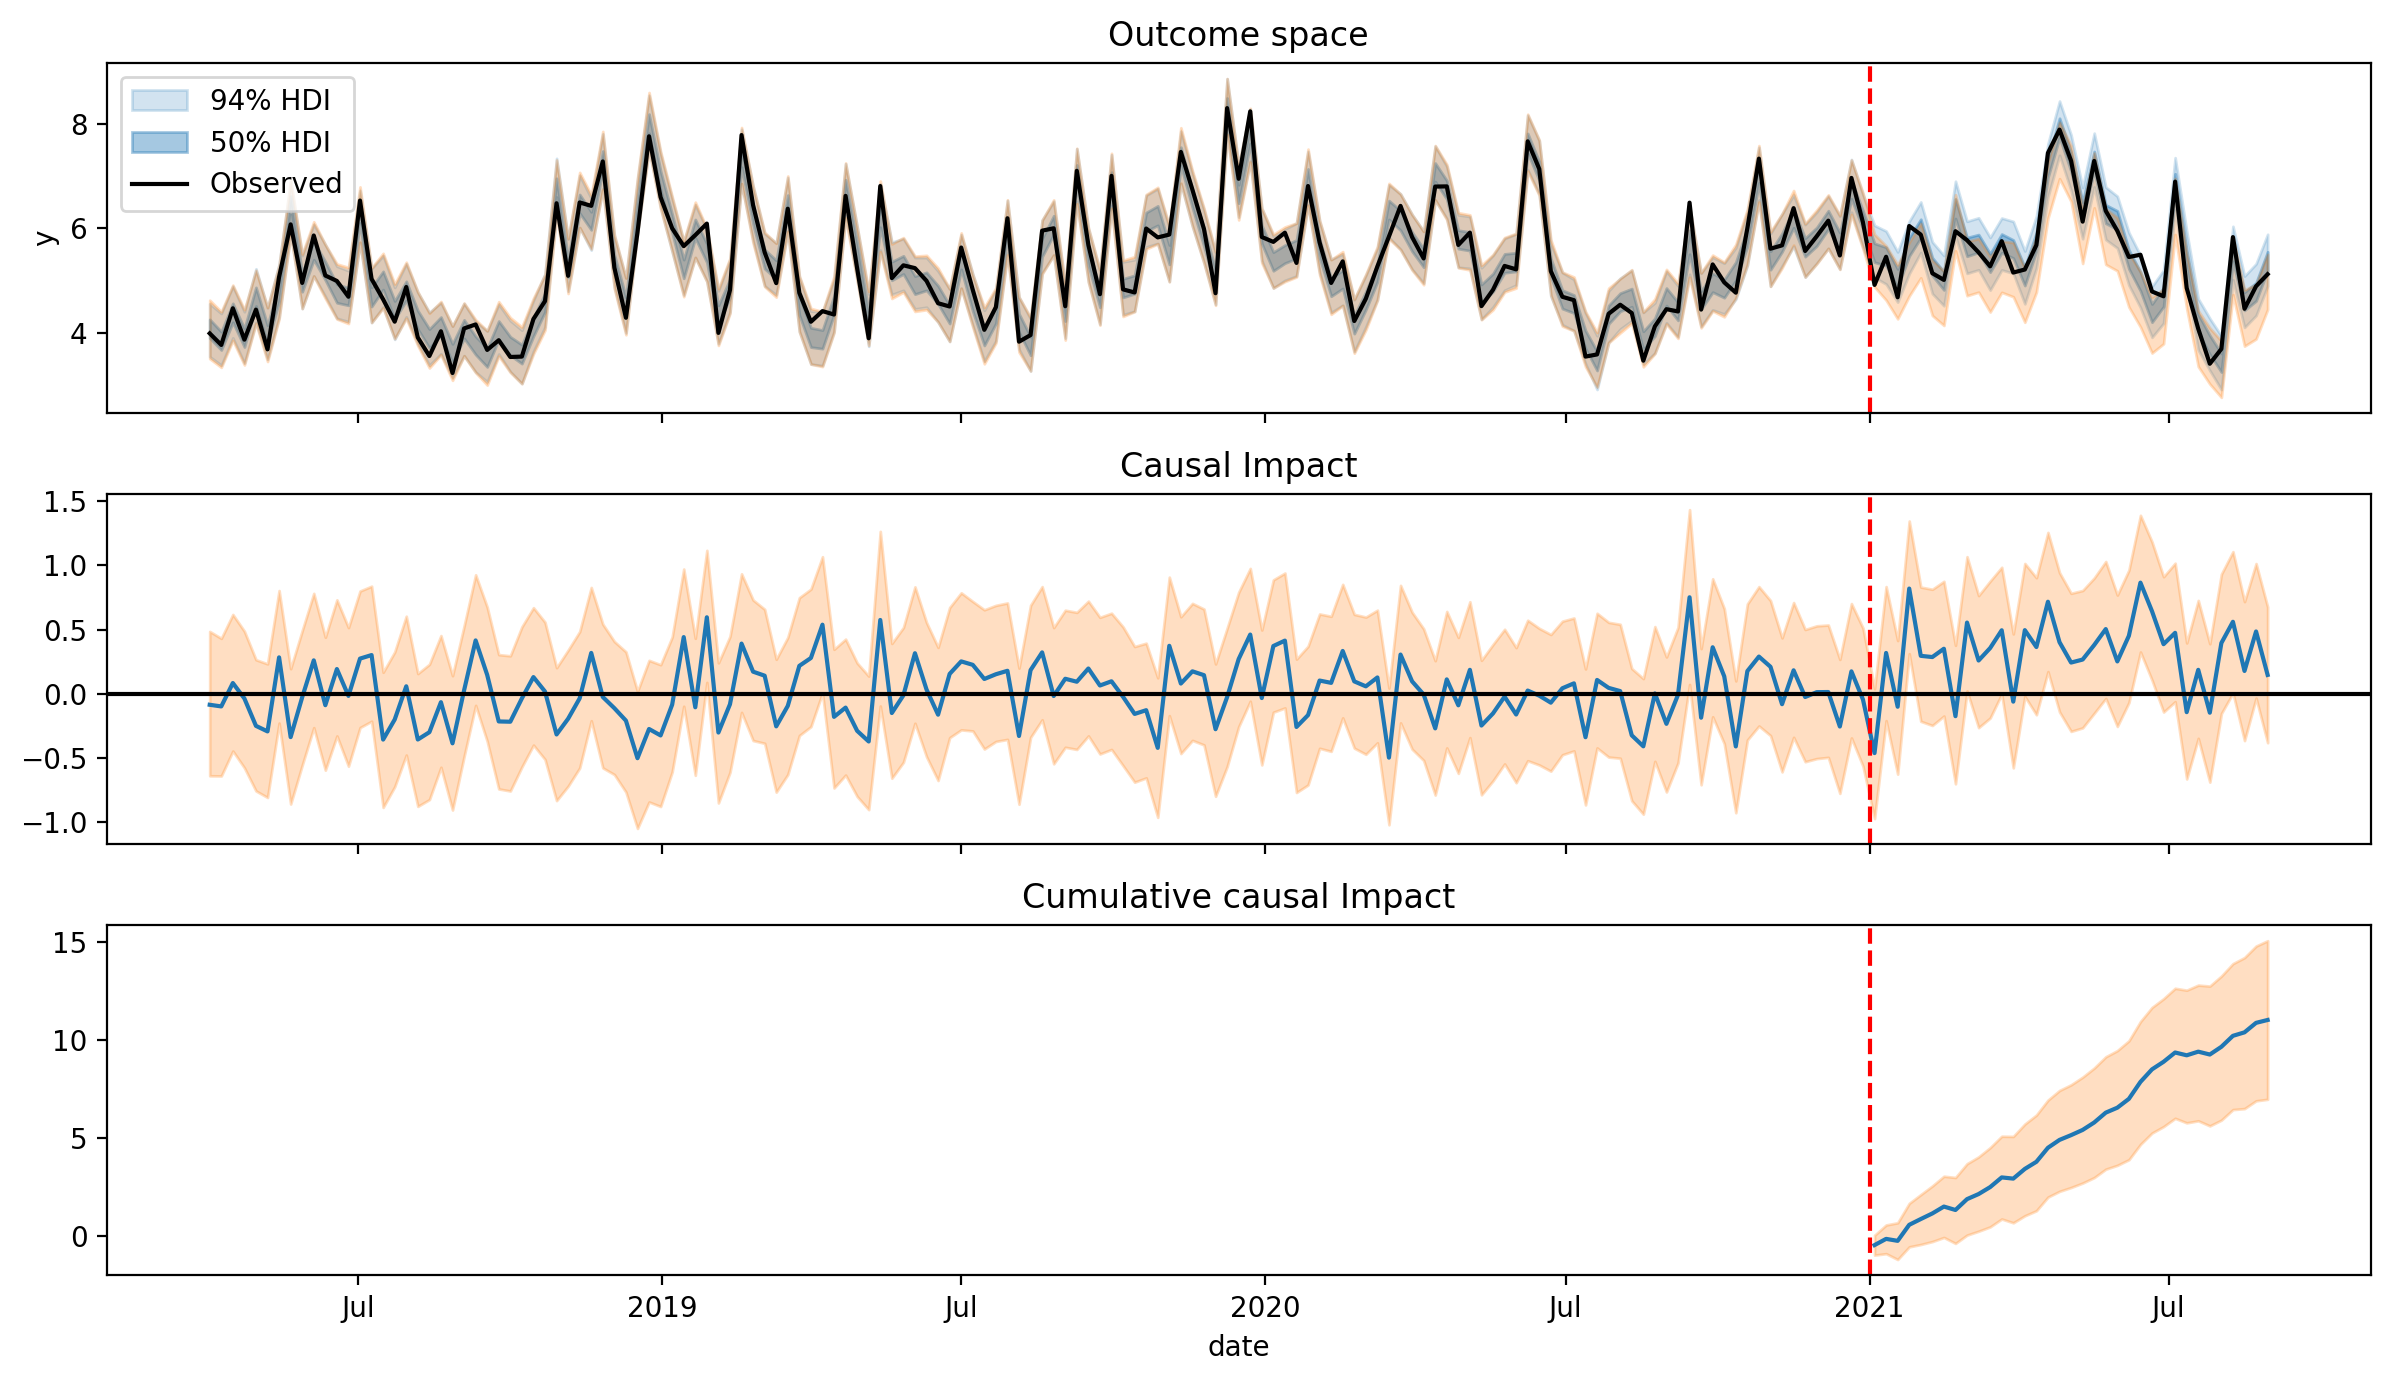

In [30]:
fig, ax = plt.subplots(3, 1, sharex=True)

# TOP PLOT - OUTCOME SPACE -------------------------------------------------------------
mmm.plot_posterior_predictive(original_scale=True, ax=ax[0])

# plot counterfactual
y_counterfactual["y"].quantile([0.025, 0.975], dim=["sample"])
ax[0].fill_between(
    X_counterfactual["date_week"].dt.to_pydatetime(),
    y_counterfactual["y"]
    .quantile([0.025, 0.975], dim=["sample"])
    .sel({"quantile": 0.025}),
    y_counterfactual["y"]
    .quantile([0.025, 0.975], dim=["sample"])
    .sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
ax[0].set(title="Outcome space", xlabel="")

# BOTTOM PLOT - COUNTERFACTUAL SPACE ---------------------------------------------------
ax[1].fill_between(
    X_counterfactual["date_week"].dt.to_pydatetime(),
    causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.025}),
    causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
# plot posterior predictive mean
causal_impact.mean(dim="sample").plot(ax=ax[1], label="casual impact mean")
ax[1].axhline(y=0, color="black", label="zero")
ax[1].set(title="Causal Impact", xlabel="")

# BOTTOM PLOT - CUMULATIVE CAUSAL IMPACT ---------------------------------------------------
# select X_counterfactual where date_week is greater than intervention_date
_X_counterfactual = X_counterfactual[X_counterfactual["date_week"] >= intervention_date]
# select counterfactual where date_week is greater than intervention_date
_causal_impact = causal_impact.sel({"date": slice(intervention_date, None)})
cum_causal_impact = _causal_impact.cumsum(dim="date")
ax[2].plot(
    _X_counterfactual["date_week"], cum_causal_impact.mean(dim="sample"), label="mean"
)
ax[2].fill_between(
    _X_counterfactual["date_week"].dt.to_pydatetime(),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.025}),
    cum_causal_impact.quantile([0.025, 0.975], dim=["sample"]).sel({"quantile": 0.975}),
    alpha=0.25,
    color="C1",
    # label=f"{label} interval",
)
ax[2].set(title="Cumulative causal Impact", xlabel="date")

# plot intervention point
for i in [0, 1, 2]:
    ax[i].axvline(
        x=pd.to_datetime(intervention_date),
        color="red",
        linestyle="--",
        label="intervention date",
    )

plt.tight_layout();

In [31]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor

Last updated: Fri Sep 13 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.27.0

pymc_marketing: 0.8.0
pytensor      : 2.20.0

seaborn   : 0.13.2
pymc      : 5.15.0
xarray    : 2024.9.0
pandas    : 2.2.2
matplotlib: 3.9.2
arviz     : 0.19.0
numpy     : 1.26.4

Watermark: 2.4.3

